# FYP Assignment 02 - Hyperparameter Tuning - MNIST Digits

In [1]:
# Basic libs
import numpy as np
import pandas as pd

# matplotlib setup for plotting
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

# For saving and loading training histories
import pickle
import os

# Filtering warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Saving and Loading Histories

In [2]:
def save_history(history, model_name):
    """Saves training history as a pickle file"""
    with open('./model_histories/' + model_name, 'wb') as history_pkl:
        pickle.dump(history.history, history_pkl)

In [3]:
def load_history(file_name):
    with open('./model_histories/' + file_name, 'rb') as history_pkl:
        return pickle.load(history_pkl)

## Loading Dataset

In [4]:
from keras.datasets import mnist

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# Train-test split has already been done for us
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [6]:
# Before proceeding, make sure you didn't mess up the order of tuple unpacking
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

In [7]:
# Sanity check: 60k-10k split?
print(f"Number of training samples: {len(X_train)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 60000
Number of test samples: 10000


## Visualizing a Single Image

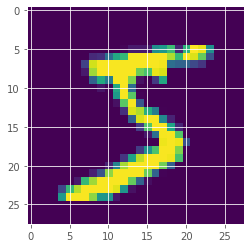

In [6]:
test_image = X_train[0]
plt.figure()
plt.imshow(test_image, cmap='viridis')

In [7]:
# Shape of images and labels?
print("Training image shape: ", test_image.shape)
print("Maximum value in image: ", test_image.max())
print("Minimum value in image: ", test_image.min())

Training image shape:  (28, 28)
Maximum value in image:  255
Minimum value in image:  0


Images will have to be unrolled or flattened before being fed to simple feedforward neural network. The pixel intensities should also be scaled. No flattening required for neural network.

## Class Distribution
Do both training and test sets contain roughly the same proportions of samples for each class?

In [8]:
# Training data 
y_train_counts = pd.DataFrame(data={'labels': y_train})['labels'].value_counts(normalize=True)

# Test data
y_test_counts = pd.DataFrame(data={'labels': y_test})['labels'].value_counts(normalize=True)

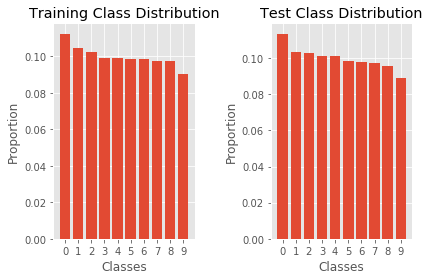

In [9]:
# Plotting normalized training and test set label counts side by side for comparison

# Training
plt.subplot(121)
plt.bar(np.unique(y_train), y_train_counts)
plt.xticks(np.unique(y_train))
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.title('Training Class Distribution')

# Test
plt.subplot(122)
plt.bar(np.unique(y_test), y_test_counts)
plt.xticks(np.unique(y_test))
plt.xlabel('Classes')
plt.ylabel('Proportion')
plt.title('Test Class Distribution')

plt.tight_layout()

Both training and test set label distributions are roughly identical, which means that we don't need to carry out stratified sampling for the training set results to be applicable to the test set data. 

## Building Preprocessing Pipeline
Data preprocessing for this model includes
1. 'Unrolling' or flattening the 28x28 images into 784-dimensional vectors of pixel intensities.
2. Pixel values should also be scaled.

Since feature scaling strategy is a hyperparameter, defining a custom data transformer class called `FeatureScaler` that will use a different scaling strategy based on an initializer argument.

## Preprocessing

### Step 1 - Cast all features to `numpy` floats

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

### Step 2 - Convert labels to 10-dimensional categorical vectors

In [10]:
from tensorflow.keras.utils import to_categorical

In [11]:
num_classes = 10;
y_train = to_categorical(y=y_train, num_classes=num_classes)
y_test = to_categorical(y=y_test, num_classes=num_classes)

In [12]:
# Sanity check
y_train.shape

(60000, 10)

In [13]:
y_test.shape

(10000, 10)

In [14]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [15]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

### Step 3 - Feature Scaling

In [16]:
def print_feature_statistics(X, scaling_strategy):
    print("Statistics for ", scaling_strategy)
    print("Mean value: ", X.mean())
    print("Std Dev: ", X.std())
    print("Minimum: ", X.min())
    print("Maximum: ", X.max())

In [17]:
def preprocess_features(X, X_train=X_train, scaling_strategy='Standard'):
    # First, convert to float32s
    X_transformed = X.astype('float32')
    
    # Scale based on specified training strategy using training data for intermediate computations
    if scaling_strategy == 'Standard':
        X_transformed -= X_train.mean()
        X_transformed /= X_train.std()
    elif scaling_strategy == 'MinMax':
        X_transformed = (X_transformed - X_train.min())/(X_train.max() - X_train.min())
    elif scaling_strategy == 'MaxAbs':
        X_transformed /= np.max(np.abs(X_train))
    elif scaling_strategy == 'Variance':
        X_transformed = (X_transformed - X_train.mean()) / (X_train.var())
        
    # Reshape array by explicitly adding a channels axis
    X_transformed = X_transformed.reshape(-1, X.shape[1], X.shape[1], 1)
    
    # Optional - printing mean/min/max/std
    # print_feature_statistics(X_transformed, scaling_strategy)
    
    # Return the transformed features
    return X_transformed

In [18]:
X_train_transformed = preprocess_features(X_train, X_train, scaling_strategy='Standard')

In [19]:
X_train_transformed.shape

(60000, 28, 28, 1)

## Base CNN

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout

In [21]:
def build_model():
    model = Sequential()

    # Convolutional base
    # First conv-pool pair
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second conv-pool pair
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Densely connected classifier
    model.add(Flatten())
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))
    
    
    # Compile with reasonable defaults for this problem
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
                  metrics=['acc'])
    
    # Return the compiled model
    return model

In [140]:
base_model = build_model()

In [48]:
# Fit the model, remember its training history
base_history = base_model.fit(X_train_transformed, y_train, 
                             batch_size=128, epochs=12,
                             validation_split=0.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/12
51000/51000 [==============================] - 33s 651us/sample - loss: 0.2262 - acc: 0.9296 - val_loss: 0.0681 - val_acc: 0.9801
Epoch 2/12
51000/51000 [==============================] - 36s 697us/sample - loss: 0.0692 - acc: 0.9785 - val_loss: 0.0493 - val_acc: 0.9849
Epoch 3/12
51000/51000 [==============================] - 36s 702us/sample - loss: 0.0490 - acc: 0.9848 - val_loss: 0.0374 - val_acc: 0.9888
Epoch 4/12
51000/51000 [==============================] - 35s 688us/sample - loss: 0.0406 - acc: 0.9869 - val_loss: 0.0363 - val_acc: 0.9891
Epoch 5/12
51000/51000 [==============================] - 33s 650us/sample - loss: 0.0325 - acc: 0.9895 - val_loss: 0.0494 - val_acc: 0.9872
Epoch 6/12
51000/51000 [==============================] - 32s 632us/sample - loss: 0.0308 - acc: 0.9902 - val_loss: 0.0367 - val_acc: 0.9906
Epoch 7/12
51000/51000 [==============================] - 33s 640us/sample - loss: 0.0261 - acc: 0.9916 -

In [22]:
def generate_train_val_plot(epochs, train_data, val_data, metric, model_name):
    plt.figure()
    plt.plot(epochs, train_data, 'b', label='Training ' + metric)
    plt.plot(epochs, val_data, 'r', label='Validation ' + metric)
    plt.grid(); plt.xlabel('Epochs'); plt.ylabel(metric); plt.legend()
    plt.title('Training vs Validation ' + metric + ' - ' + model_name)

In [23]:
def plot_history_data(history, model_name):
    history = history.history
    epochs = list(range(1, len(history['loss']) + 1))
    loss = history['loss']
    val_loss = history['val_loss']
    acc = history['acc']
    val_acc = history['val_acc']
    generate_train_val_plot(epochs, loss, val_loss, 'Loss', model_name=model_name)
    generate_train_val_plot(epochs, acc, val_acc, 'Accuracy', model_name=model_name)

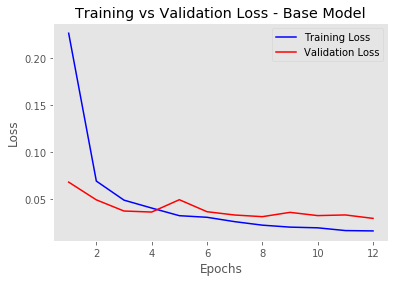

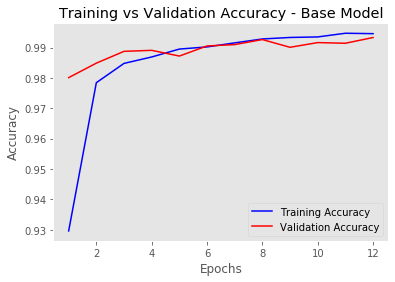

In [72]:
plot_history_data(base_history, model_name='Base Model')

## Testing History R/W

In [26]:
save_history(base_history, 'base_model_history')

NameError: name 'base_history' is not defined

In [27]:
loaded_base_history = load_history('base_model_history')

# Hyperparameter 1 - Feature Scaling

## Preprocessing Data

In [25]:
X_train_minmax = preprocess_features(X_train, X_train, scaling_strategy='MinMax')
X_train_standard = preprocess_features(X_train, X_train, scaling_strategy='Standard')
X_train_variance = preprocess_features(X_train, X_train, scaling_strategy='Variance')
X_train_maxabs = preprocess_features(X_train, X_train, scaling_strategy='MaxAbs')

## MinMax Scaling

In [145]:
scaling_minmax_history = build_model().fit(X_train_minmax, y_train, batch_size=128, epochs=12, validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 35s 721us/sample - loss: 0.2799 - acc: 0.9123 - val_loss: 0.0871 - val_acc: 0.9743
Epoch 2/12
48000/48000 [==============================] - 38s 798us/sample - loss: 0.0832 - acc: 0.9744 - val_loss: 0.0528 - val_acc: 0.9843
Epoch 3/12
48000/48000 [==============================] - 37s 776us/sample - loss: 0.0571 - acc: 0.9821 - val_loss: 0.0394 - val_acc: 0.9888
Epoch 4/12
48000/48000 [==============================] - 35s 722us/sample - loss: 0.0441 - acc: 0.9862 - val_loss: 0.0392 - val_acc: 0.9885
Epoch 5/12
48000/48000 [==============================] - 37s 767us/sample - loss: 0.0377 - acc: 0.9880 - val_loss: 0.0379 - val_acc: 0.9895
Epoch 6/12
48000/48000 [==============================] - 35s 729us/sample - loss: 0.0329 - acc: 0.9896 - val_loss: 0.0332 - val_acc: 0.9907
Epoch 7/12
48000/48000 [==============================] - 36s 753us/sample - loss: 0.0286 - acc: 0.9911 

In [146]:
save_history(scaling_minmax_history, 'scaling_minmax')

## Standard Scaling

In [147]:
scaling_standard_history = build_model().fit(X_train_standard, y_train, batch_size=128, epochs=12, validation_split=0.2)
save_history(scaling_standard_history, 'scaling_standard')

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 32s 664us/sample - loss: 0.2349 - acc: 0.9259 - val_loss: 0.0687 - val_acc: 0.9823
Epoch 2/12
48000/48000 [==============================] - 33s 694us/sample - loss: 0.0696 - acc: 0.9785 - val_loss: 0.0460 - val_acc: 0.9858
Epoch 3/12
48000/48000 [==============================] - 35s 721us/sample - loss: 0.0498 - acc: 0.9841 - val_loss: 0.0375 - val_acc: 0.9887
Epoch 4/12
48000/48000 [==============================] - 36s 751us/sample - loss: 0.0411 - acc: 0.9874 - val_loss: 0.0336 - val_acc: 0.9901
Epoch 5/12
48000/48000 [==============================] - 36s 751us/sample - loss: 0.0338 - acc: 0.9895 - val_loss: 0.0336 - val_acc: 0.9905
Epoch 6/12
48000/48000 [==============================] - 34s 711us/sample - loss: 0.0301 - acc: 0.9906 - val_loss: 0.0347 - val_acc: 0.9896
Epoch 7/12
48000/48000 [==============================] - 30s 622us/sample - loss: 0.0268 - acc: 0.9910 

## MaxAbs Scaling

In [148]:
scaling_maxabs_history = build_model().fit(X_train_maxabs, y_train, batch_size=128, epochs=12, validation_split=0.2)
save_history(scaling_maxabs_history, 'scaling_maxabs')

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 33s 689us/sample - loss: 0.2825 - acc: 0.9105 - val_loss: 0.0746 - val_acc: 0.9756
Epoch 2/12
48000/48000 [==============================] - 32s 666us/sample - loss: 0.0812 - acc: 0.9746 - val_loss: 0.0549 - val_acc: 0.9831
Epoch 3/12
48000/48000 [==============================] - 33s 691us/sample - loss: 0.0555 - acc: 0.9824 - val_loss: 0.0506 - val_acc: 0.9852
Epoch 4/12
48000/48000 [==============================] - 35s 734us/sample - loss: 0.0447 - acc: 0.9863 - val_loss: 0.0350 - val_acc: 0.9887
Epoch 5/12
48000/48000 [==============================] - 36s 748us/sample - loss: 0.0373 - acc: 0.9880 - val_loss: 0.0399 - val_acc: 0.9898
Epoch 6/12
48000/48000 [==============================] - 33s 680us/sample - loss: 0.0322 - acc: 0.9900 - val_loss: 0.0368 - val_acc: 0.9889
Epoch 7/12
48000/48000 [==============================] - 32s 674us/sample - loss: 0.0284 - acc: 0.9909 

## Variance Scaling

In [149]:
scaling_variance_history = build_model().fit(X_train_variance, y_train, batch_size=128, epochs=12, 
                                            validation_split=0.2)
save_history(scaling_variance_history, 'scaling_variance')

Train on 48000 samples, validate on 12000 samples
Epoch 1/12
48000/48000 [==============================] - 33s 685us/sample - loss: 0.5135 - acc: 0.8468 - val_loss: 0.1556 - val_acc: 0.9560
Epoch 2/12
48000/48000 [==============================] - 31s 640us/sample - loss: 0.1417 - acc: 0.9570 - val_loss: 0.0931 - val_acc: 0.9718
Epoch 3/12
48000/48000 [==============================] - 33s 688us/sample - loss: 0.0970 - acc: 0.9702 - val_loss: 0.0694 - val_acc: 0.9789
Epoch 4/12
48000/48000 [==============================] - 32s 675us/sample - loss: 0.0762 - acc: 0.9765 - val_loss: 0.0573 - val_acc: 0.9832
Epoch 5/12
48000/48000 [==============================] - 31s 650us/sample - loss: 0.0626 - acc: 0.9799 - val_loss: 0.0579 - val_acc: 0.9833
Epoch 6/12
48000/48000 [==============================] - 30s 632us/sample - loss: 0.0565 - acc: 0.9824 - val_loss: 0.0532 - val_acc: 0.9839
Epoch 7/12
48000/48000 [==============================] - 31s 637us/sample - loss: 0.0484 - acc: 0.9846 

## Comparing Losses and Accuracies

In [151]:
# Store all training histories into a dictionary
training_histories = {
    'standard': scaling_standard_history.history, 
    'maxabs': scaling_maxabs_history.history, 
    'minmax': scaling_minmax_history.history,
    'variance': scaling_variance_history.history
}

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the s

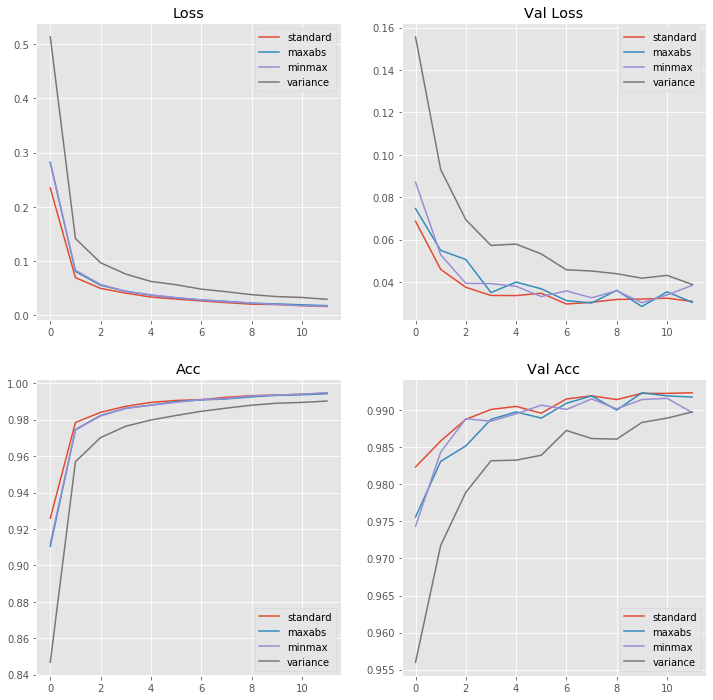

In [155]:
plt.figure(figsize=(12, 12))
for scaling_strategy, history in training_histories.items():
    plt.subplot(221)
    plt.plot(history['loss'], label=scaling_strategy)
    plt.title('Loss'); plt.legend();
    
    plt.subplot(222)
    plt.plot(history['val_loss'], label=scaling_strategy)
    plt.title('Val Loss'); plt.legend();
    
    plt.subplot(223)
    plt.plot(history['acc'], label=scaling_strategy)
    plt.title('Acc'); plt.legend();
    
    plt.subplot(224)
    plt.plot(history['val_acc'], label=scaling_strategy)
    plt.title('Val Acc'); plt.legend()

### Interpretation
- Across all epochs, the `Standard` scaling strategy appears to give the highest training set accuracy and training set loss, with the `MaxAbs` scaling strategy a close second. 
- Worst training and test set accuracy/loss is achieved by the `Variance` scaling strategy. 
- For this problem, the `MaxAbs` and `MinMax` scaling strategies gave virtually identical training set performance, which is to be expected because their formulae evaluate to the same experession.
    - Differences in these scaling strategies for the validation set are due to sampling noise. 
    - `MaxAbs` uses two calls to `np` functions, which may be faster than manual subtraction and division. 
- Intuitively, I would expect the `MaxAbs` or `MinMax` strategy to give the highest accuracy since these strategies put neural network inputs in range $[0, 1]$. 
- Validation set results show that standardization is a better strategy. Does this mean that the pixel values are normally distributed across the dataset?
    - This could be true because the training set size is very large, so any sampling noise in an image is virtually nonexistent, so as far as the model is concerned, the input pixel intensities are truly random in nature. This is why a Gaussian distribution works well.
    - However, a drawback of this scaling strategy is the implicit assumption that some pixel values will be **negative** (see min value of standardized features below). This does not make sense for an image where pixel values are either 0 or 1.
- **TODO**: Discuss why `Standard` is giving ostensibly better performance than `MinMax` and `MaxAbs`.
- **TODO**: Calculate mean epoch training times for `MaxAbs` and `MinMax` strategies to decide which one is faster.

### Best Hyperparameter Value: `MinMax`
- It gives virtually the same test/validation accuracy and loss as the `Standard` scaling strategy.
- However, it does so without making the model implicitly (and incorrectly) assume negative values for features.
- For a large enough test set of this problem, the `MinMax` and `MaxAbs`scaling strategies will give roughly identical performance (as is evident in training set results). Any deviations in their validation set performances is largely due to the sampling noise (12k samples vs 48k samples).
- As there are no negative values present in the features, it is useless to make an extra call to `np.max` and `np.abs`. However, cursory look at training history shows that this may be faster than `MinMax`.

In [28]:
print_feature_statistics(X_train_standard, 'Standard')
# Minimum value is -0.42, max is 2.82, range is not bounded - this is bad

Statistics for  Standard
Mean value:  -3.4560264e-07
Std Dev:  0.9999998
Minimum:  -0.42407447
Maximum:  2.8215446


In [29]:
print_feature_statistics(X_train_minmax, 'MinMax')
# Identical to maxabs stats

Statistics for  MinMax
Mean value:  0.13066062
Std Dev:  0.30810776
Minimum:  0.0
Maximum:  1.0


In [30]:
print_feature_statistics(X_train_maxabs, 'MaxAbs')

Statistics for  MaxAbs
Mean value:  0.13066062
Std Dev:  0.30810776
Minimum:  0.0
Maximum:  1.0


# Hyperparameter 2 - Epochs

In [33]:
X_train = preprocess_features(X_train, X_train, scaling_strategy='MinMax')

In [34]:
epochs_model = build_model()

In [35]:
EPOCHS = 16

In [36]:
epochs_model_history = epochs_model.fit(X_train, y_train, batch_size=128, epochs=EPOCHS,
                                        validation_split=0.2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/16
48000/48000 [==============================] - 33s 679us/sample - loss: 0.2829 - acc: 0.9124 - val_loss: 0.0753 - val_acc: 0.9777
Epoch 2/16
48000/48000 [==============================] - 37s 774us/sample - loss: 0.0804 - acc: 0.9747 - val_loss: 0.0531 - val_acc: 0.9853
Epoch 3/16
48000/48000 [==============================] - 38s 788us/sample - loss: 0.0554 - acc: 0.9822 - val_loss: 0.0434 - val_acc: 0.9881
Epoch 4/16
48000/48000 [==============================] - 31s 653us/sample - loss: 0.0452 - acc: 0.9857 - val_loss: 0.0370 - val_acc: 0.9895
Epoch 5/16
48000/48000 [==============================] - 33s 688us/sample - loss: 0.0393 - acc: 0.9877 - val_loss: 0.0397 - val_acc: 0.9891
Epoch 6/16
48000/48000 [==============================] - 34s 715us/sample - loss: 0.0332 - acc: 0.9893 - val_loss: 0.0365 - val_acc: 0.9897
Epoch 7/16
48000/48000 [==============================] - 39s 821us/sample - loss: 0.0284 - acc: 0.9907 

In [37]:
save_history(epochs_model_history, 'epochs_16')

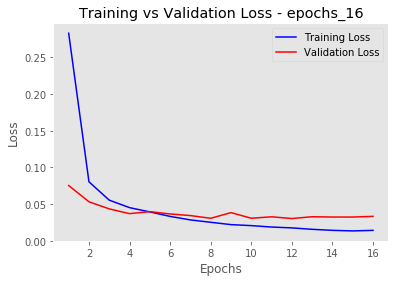

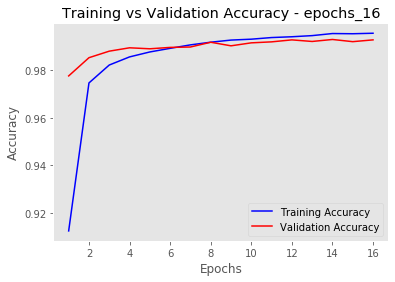

In [38]:
plot_history_data(epochs_model_history, 'epochs_16')

## Plotting Epoch History Data
Loading all training histories and plotting maximim accuracies/minimum losses for each.

In [41]:
epoch_histories = {
    '12': load_history('scaling_minmax'),
    '16': load_history('epochs_16'),
    '24': load_history('epochs_24')
}

In [45]:
# Creating a dictionary to populate with minimum losses and maximum accs
# for each metric of each dictionary in the epoch
epoch_data = {
    'loss': {},
    'val_loss': {},
    'acc': {},
    'val_acc': {}
}

In [46]:
for key, item in epoch_histories.items():
    epoch_data['loss'][key] = np.min(item['loss'])
    epoch_data['val_loss'][key] = np.min(item['val_loss'])
    epoch_data['acc'][key] = np.max(item['acc'])
    epoch_data['val_acc'][key] = np.max(item['val_acc'])

In [55]:
epochs_df = pd.DataFrame.from_dict(epoch_data)

(0.98, 1.0)

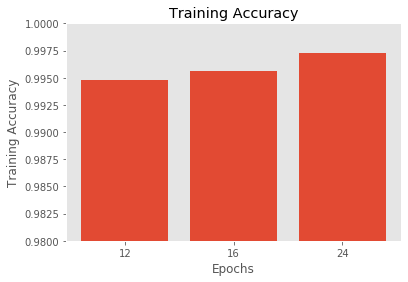

In [73]:
plt.bar(epochs_df.index, epochs_df['acc'])
plt.xlabel('Epochs'); plt.ylabel('Training Accuracy')
plt.grid(); plt.title('Training Accuracy')
plt.ylim([0.98, 1.0])

(0.0, 0.035)

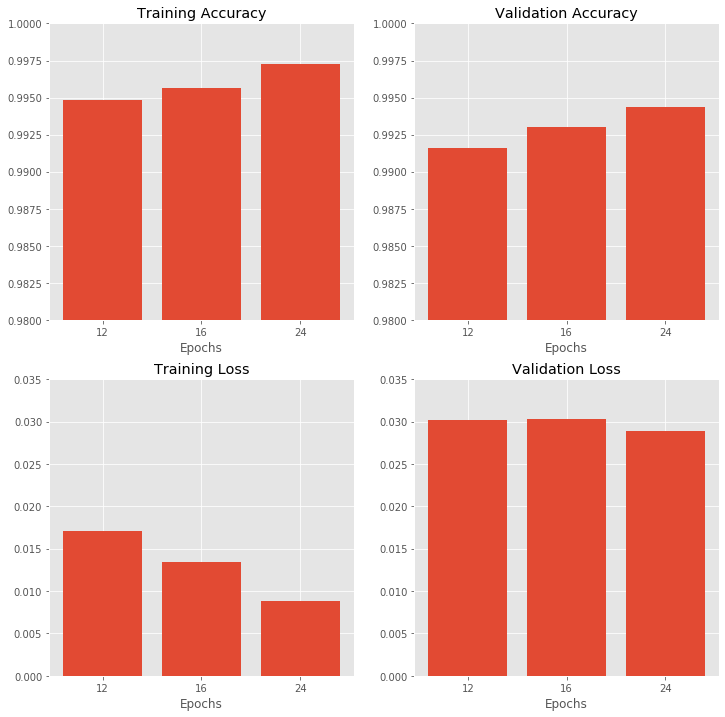

In [83]:
# Figure should be YUGE
fig = plt.figure(figsize=(12, 12))

# Separate axes references for each subplot 
ax_acc = fig.add_subplot(221)
ax_acc.bar(epochs_df.index, epochs_df['acc'])
plt.ylim([0.98, 1.0]); plt.title('Training Accuracy'); plt.xlabel('Epochs');

ax_val_acc = fig.add_subplot(222)
ax_val_acc.bar(epochs_df.index, epochs_df['val_acc'])
plt.ylim([0.98, 1.0]); plt.title('Validation Accuracy'); plt.xlabel('Epochs');

ax_loss = fig.add_subplot(223)
ax_loss.bar(epochs_df.index, epochs_df['loss']); plt.title('Training Loss'); 
plt.xlabel('Epochs'); plt.ylim([0.00, 0.035]);


ax_val_loss = fig.add_subplot(224)
ax_val_loss.bar(epochs_df.index, epochs_df['val_loss'])
plt.xlabel('Epochs'); plt.title('Validation Loss'); plt.ylim([0.00, 0.035]);

### Interpretation
- Validation set accuracy increases only incrementally with increases in epochs.
    - ~0.029% increase with 8 additional epochs
    - ~0.035% increse with 16 additional epochs
- Improvement in model performance is incremental at best, but considering that base model accuracy was already 99.2% to begin with, this is still promising.
- As loss continues to decrease while accuracy continues to increase with increasing epochs, I should probably test for more epochs until point of diminishing returns is reached. 

## Best Epoch Value - 24

# Hyperparameter 3 - 